In [3]:
#Dependencies
from functools import partial
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import cv
from optuna import create_study
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.integration import XGBoostPruningCallback
from optuna.distributions import IntDistribution, FloatDistribution
from optuna.samplers import TPESampler
from optuna import Trial
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
X_full = pd.read_csv('/workspaces/2025SE-Mike.N-HSC-AT2/data/concrete_preprocessed.csv')
y = X_full['strength']
X = X_full.drop(['strength'], axis=1)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cement                           996 non-null    float64
 1   blast_furnace_slag               996 non-null    float64
 2   fly_ash                          996 non-null    float64
 3   water                            996 non-null    float64
 4   superplasticizer                 996 non-null    float64
 5   coarse_aggregate                 996 non-null    float64
 6   fine_aggregate                   996 non-null    float64
 7   age                              996 non-null    float64
 8   cement_to_water_ratio            996 non-null    float64
 9   fine_aggregate_to_water_ratio    996 non-null    float64
 10  coarse_aggregate_to_water_ratio  996 non-null    float64
dtypes: float64(11)
memory usage: 85.7 KB


In [6]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 996 entries, 0 to 995
Series name: strength
Non-Null Count  Dtype  
--------------  -----  
996 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


**Model Training** \
We divide the training phase into 2 phases:
* In the 1st phase, we use Optuna to find the best tree parameters with a medium learning rate to improve trial speeds.
* In the 2nd phase, we use a small learning rate to find the best number of boosting rounds.

In [7]:
model = XGBRegressor()
train_time = 60*5 #15 minutes

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train, 
                     enable_categorical=True)
dvalid = xgb.DMatrix(data=X_val, label=y_val, 
                     enable_categorical=True)
dtest = xgb.DMatrix(data=X_test, label=y_test, 
                    enable_categorical=True)
dtrainvalid = xgb.DMatrix(data=X_train_valid, 
                          label=y_train_valid, 
                          enable_categorical=True)

# Define the callback to stop the optimization when the trial keep being pruned. 
# The number of pruned trials is defined by the threshold.
class StopWhenTrialKeepBeingPrunedCallback:
    def __init__(self, threshold: int):
        self.threshold = threshold
        self._consequtive_pruned_count = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.state == optuna.trial.TrialState.PRUNED:
            self._consequtive_pruned_count += 1
        else:
            self._consequtive_pruned_count = 0

        if self._consequtive_pruned_count >= self.threshold:
            study.stop()

# Define the objective function to optimize the hyperparameters of the XGBoost model.
def objective_GB(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse', # root mean squared error
        'tree_method': trial.suggest_categorical('tree_method', ['approx', 'hist']), 
        'learning_rate': trial.suggest_float('learning_rate', 0.2, 0.5), # Most important parameter.
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 40, log=True), # L2 regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 40, log= True), # L1 regularization
        'max_depth': trial.suggest_int('max_depth', 3, 12), # Tree depth
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 200), # Min weight of each child.
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), 
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),       
    }
    
    # integrated pruning for stopping unpromising trials.
    xgb_callback = XGBoostPruningCallback(trial, f'valid-rmse')

    model = XGBRegressor(random_state= 1, **params)
    
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=1000,
                      evals=[(dtrain, 'train'), (dvalid, 'valid')],
                      early_stopping_rounds=50,
                      verbose_eval=0,                      
                      callbacks=[xgb_callback],
                      )

    return model.best_score

# Create the study and optimize the objective function.
# Threshold is 10.
study_stop_cb = StopWhenTrialKeepBeingPrunedCallback(200)
study_gb = create_study(direction="minimize", sampler = TPESampler(seed = 42))
study_gb.optimize(objective_GB, timeout = train_time, n_trials= 3000, callbacks = [study_stop_cb])
study_gb.best_params

[I 2025-04-02 23:05:09,398] A new study created in memory with name: no-name-d3e86a77-6128-4028-906c-f1efcf3b8550
[I 2025-04-02 23:05:09,470] Trial 0 finished with value: 16.114598998601426 and parameters: {'tree_method': 'hist', 'learning_rate': 0.4195981825434215, 'reg_lambda': 0.5689344850030498, 'reg_alpha': 0.005224047812087992, 'max_depth': 4, 'min_child_weight': 12, 'subsample': 0.9330880728874675, 'colsample_bynode': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'colsample_bylevel': 0.5102922471479012}. Best is trial 0 with value: 16.114598998601426.
[I 2025-04-02 23:05:09,620] Trial 1 finished with value: 16.613993120916373 and parameters: {'tree_method': 'approx', 'learning_rate': 0.26370173320348284, 'reg_lambda': 0.006867037309970066, 'reg_alpha': 0.006982943964830307, 'max_depth': 6, 'min_child_weight': 105, 'subsample': 0.7159725093210578, 'colsample_bynode': 0.645614570099021, 'colsample_bytree': 0.8059264473611898, 'colsample_bylevel': 0.569746930326021}. 

[I 2025-04-02 23:05:10,746] Trial 22 finished with value: 15.868760883515238 and parameters: {'tree_method': 'hist', 'learning_rate': 0.3603752400543475, 'reg_lambda': 0.1975291411603733, 'reg_alpha': 0.002782461547042498, 'max_depth': 9, 'min_child_weight': 22, 'subsample': 0.9521562873182934, 'colsample_bynode': 0.5440443443137871, 'colsample_bytree': 0.9534982722716281, 'colsample_bylevel': 0.6700501576639312}. Best is trial 14 with value: 15.629387436525578.
[I 2025-04-02 23:05:10,852] Trial 23 finished with value: 15.944989503925347 and parameters: {'tree_method': 'hist', 'learning_rate': 0.36709234404429797, 'reg_lambda': 1.4158201018411496, 'reg_alpha': 0.002162049346735812, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9657162802607198, 'colsample_bynode': 0.6344033301804961, 'colsample_bytree': 0.9435849383457133, 'colsample_bylevel': 0.6928111279607773}. Best is trial 14 with value: 15.629387436525578.
[I 2025-04-02 23:05:10,885] Trial 24 pruned. Trial was pruned at i

{'tree_method': 'hist',
 'learning_rate': 0.39863956598229794,
 'reg_lambda': 0.92457064534831,
 'reg_alpha': 0.0012465313132076418,
 'max_depth': 10,
 'min_child_weight': 5,
 'subsample': 0.9908694324044368,
 'colsample_bynode': 0.5695752146388356,
 'colsample_bytree': 0.9555642472791113,
 'colsample_bylevel': 0.6569817240771461}

In [8]:
base_model = XGBRegressor(random_state=1)
cross_val_score(base_model, X_train_valid, y_train_valid, scoring='neg_mean_absolute_error', cv = 5)

array([-11.56263529, -11.3095334 , -10.88514568, -12.08560053,
       -10.26554603])

In [ ]:
plot_param_importances(study_gb)

In [ ]:
plot_optimization_history(study_gb)

In [ ]:
low_learning_rate = 0.001
params = study_gb.best_params
params['learning_rate'] = low_learning_rate
model_stage2 = xgb.train(params=params, dtrain=dtrain, 
                         num_boost_round=5000,
                         evals=[(dtrain, 'train'), (dvalid, 'valid')],
                         early_stopping_rounds=50,
                         verbose_eval=0)

Find the best number of boosting rounds.

In [ ]:
def score_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:
    y_true = dmat.get_label() 
    y_pred = model.predict(dmat) 
    return mean_absolute_error(y_true, y_pred)

print('Stage 2')
print(f'best score = {score_model(model_stage2, dvalid)}')
print(f'best boosting round: {model_stage2.best_iteration}')

Stage 2
best score = 12.128686904907227
best boosting round: 2471


In [ ]:
model_final = xgb.train(params=study_gb.best_params, dtrain=dtrainvalid, 
                        num_boost_round=model_stage2.best_iteration,
                        verbose_eval=0)

Evaluation of final model.

In [ ]:
print('Final Model')
print(f'test score = {score_model(model_final, dtest)}')
print('Parameters')
for i, j in params.items():
    print(i, ':', j)
print(f'num_boost_round: {model_stage2.best_iteration}')

Final Model
test score = 11.591076850891113
Parameters
tree_method : hist
learning_rate : 0.001
reg_lambda : 0.2351028496158549
reg_alpha : 0.05879734464400952
max_depth : 5
min_child_weight : 1
subsample : 0.9160465684491753
colsample_bynode : 0.9699586846471081
colsample_bytree : 0.6576513098358873
colsample_bylevel : 0.8275812590568429
max_bin : 546
num_boost_round: 2471


Feature importance: By weight

In [ ]:
model_final.get_score(importance_type='weight')

{'cement': 4727.0,
 'blast_furnace_slag': 2826.0,
 'fly_ash': 1876.0,
 'water': 3487.0,
 'superplasticizer': 3041.0,
 'coarse_aggregate': 4431.0,
 'fine_aggregate': 4329.0,
 'age': 6906.0,
 'cement_to_water_ratio': 3985.0,
 'fine_aggregate_to_water_ratio': 4177.0,
 'coarse_aggregate_to_water_ratio': 3918.0}

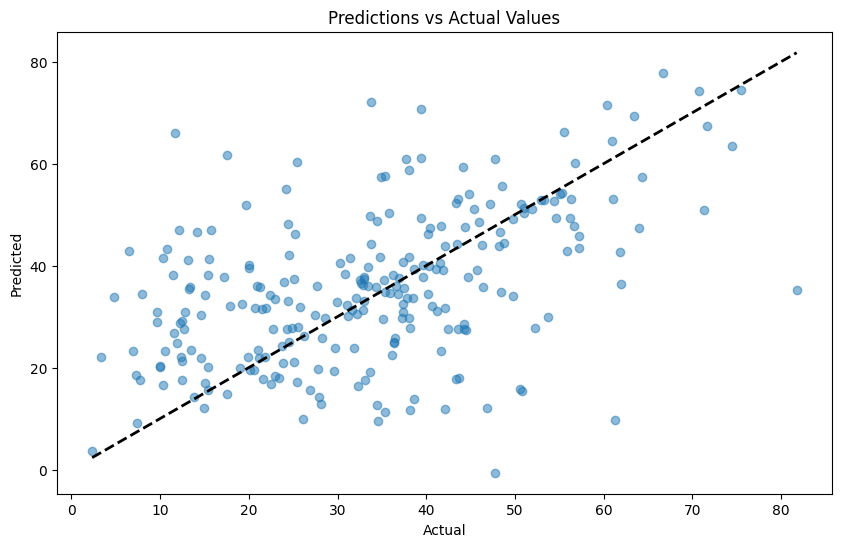

In [ ]:
# Fit the model with the best parameters from the study
model = XGBRegressor(**study_gb.best_params, enable_categorical=True)
model = xgb.train(params=study_gb.best_params, dtrain=dtrainvalid, 
                        num_boost_round=model_stage2.best_iteration,
                        verbose_eval=0)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual Values')
plt.show()

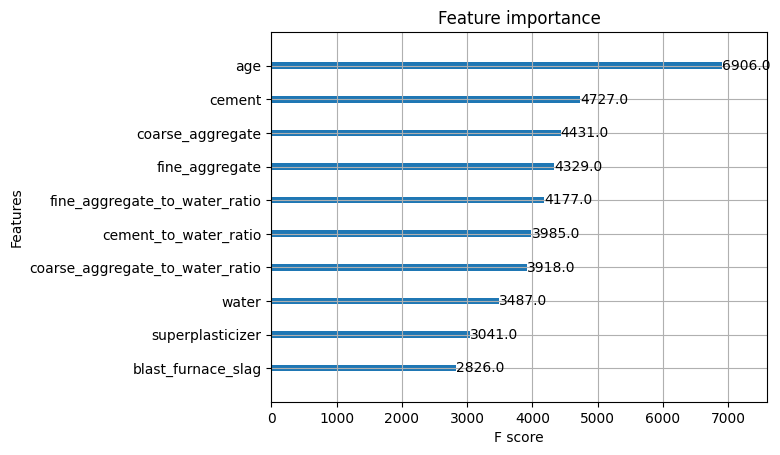

In [ ]:
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.show()

In [ ]:
cv_results = xgb.cv(params = study_gb.best_params,
        dtrain = dtest,
        num_boost_round=model_stage2.best_iteration,
        metrics = 'mape',
        seed = 42)

In [ ]:
cv_results

,train-mape-mean,train-mape-std,test-mape-mean,test-mape-std
0,0.527403,0.032201,0.633749,0.101544
1,0.424329,0.026118,0.580945,0.093803
2,0.357124,0.030640,0.592714,0.076566
3,0.307482,0.025149,0.596322,0.086156
4,0.281418,0.020238,0.587757,0.080484
...,...,...,...,...
2466,0.000157,0.000001,0.570633,0.080056
2467,0.000157,0.000002,0.570632,0.080055
2468,0.000157,0.000002,0.570632,0.080055
2469,0.000157,0.000002,0.570632,0.080055


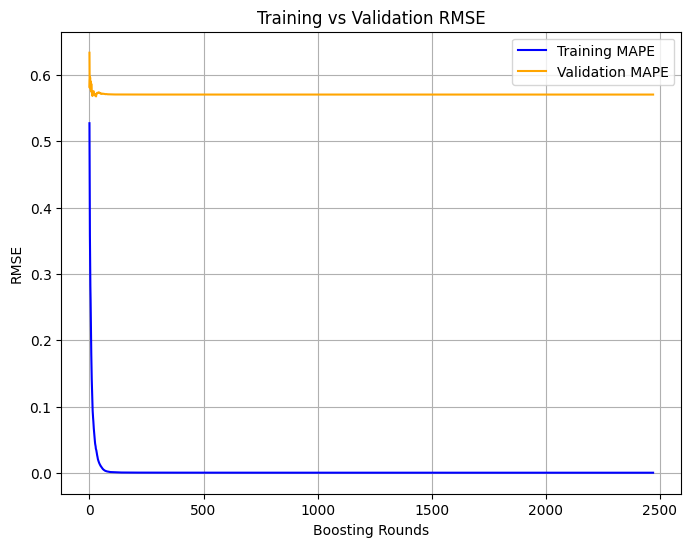

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results['train-mape-mean'], label='Training MAPE', color='blue')
plt.plot(cv_results['test-mape-mean'], label='Validation MAPE', color='orange')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()